In [4]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

In [5]:
from haystack import Document
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from data_pipeline import fetch_research_papers

dataset = fetch_research_papers("AI", max_results=2)

dataset = [
    {"content" : document.summary,
     "meta" : {
         "title" : document.title,
         "published" : document.published,
         "author" : document.author,
         "category" : document.arxiv_primary_category["term"],
        }
    }  
    for document in dataset
]


docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=docs)

Request URL: http://export.arxiv.org/api/query?search_query=all:AI&start=0&max_results=2


2

In [6]:
from haystack_experimental.chat_message_stores.in_memory import InMemoryChatMessageStore
from haystack_experimental.components.retrievers import ChatMessageRetriever
from haystack_experimental.components.writers import ChatMessageWriter

# Memory components
memory_store = InMemoryChatMessageStore()
memory_retriever = ChatMessageRetriever(memory_store)
memory_writer = ChatMessageWriter(memory_store)

In [7]:
from haystack.dataclasses import ChatMessage

system_message = ChatMessage.from_system("You are a helpful AI assistant using provided supporting documents and conversation history to assist humans")

user_message_template ="""Given the conversation history and the provided supporting documents, give a brief answer to the question.
Note that supporting documents are not part of the conversation. If question can't be answered from supporting documents, say so.

    Conversation history:
    {% for memory in memories %}
        {{ memory.text }}
    {% endfor %}

    Supporting documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""
user_message = ChatMessage.from_user(user_message_template)

In [8]:
from itertools import chain
from typing import Any

from haystack import component
from haystack.core.component.types import Variadic


@component
class ListJoiner:
    def __init__(self, _type: Any):
        component.set_output_types(self, values=_type)

    def run(self, values: Variadic[Any]):
        result = list(chain(*values))
        return {"values": result}

In [9]:
query_rephrase_template = """
        Rewrite the question for search while keeping its meaning and key terms intact.
        If the conversation history is empty, DO NOT change the query.
        Use conversation history only if necessary, and avoid extending the query with your own knowledge.
        If no changes are needed, output the current question as is.

        Conversation history:
        {% for memory in memories %}
            {{ memory.text }}
        {% endfor %}

        User Query: {{query}}
        Rewritten Query:
"""

In [10]:
from typing import List
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder, PromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators import OpenAIGenerator
from haystack.components.converters import OutputAdapter

conversational_rag = Pipeline()

# components for query rephrasing
conversational_rag.add_component("query_rephrase_prompt_builder", PromptBuilder(query_rephrase_template))
conversational_rag.add_component("query_rephrase_llm", OpenAIGenerator())
conversational_rag.add_component("list_to_str_adapter", OutputAdapter(template="{{ replies[0] }}", output_type=str))

# components for RAG
conversational_rag.add_component("retriever", InMemoryBM25Retriever(document_store=document_store, top_k=3))
conversational_rag.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
conversational_rag.add_component("llm", OpenAIChatGenerator())

# components for memory
conversational_rag.add_component("memory_retriever", ChatMessageRetriever(memory_store))
conversational_rag.add_component("memory_writer", ChatMessageWriter(memory_store))
conversational_rag.add_component("memory_joiner", ListJoiner(List[ChatMessage]))

# connections for query rephrasing
conversational_rag.connect("memory_retriever", "query_rephrase_prompt_builder.memories")
conversational_rag.connect("query_rephrase_prompt_builder.prompt", "query_rephrase_llm")
conversational_rag.connect("query_rephrase_llm.replies", "list_to_str_adapter")
conversational_rag.connect("list_to_str_adapter", "retriever.query")

# connections for RAG
conversational_rag.connect("retriever.documents", "prompt_builder.documents")
conversational_rag.connect("prompt_builder.prompt", "llm.messages")
conversational_rag.connect("llm.replies", "memory_joiner")

# connections for memory
conversational_rag.connect("memory_joiner", "memory_writer")
conversational_rag.connect("memory_retriever", "prompt_builder.memories")

🚅 Components
  - query_rephrase_prompt_builder: PromptBuilder
  - query_rephrase_llm: OpenAIGenerator
  - list_to_str_adapter: OutputAdapter
  - retriever: InMemoryBM25Retriever
  - prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
  - memory_retriever: ChatMessageRetriever
  - memory_writer: ChatMessageWriter
  - memory_joiner: ListJoiner
🛤️ Connections
  - query_rephrase_prompt_builder.prompt -> query_rephrase_llm.prompt (str)
  - query_rephrase_llm.replies -> list_to_str_adapter.replies (List[str])
  - list_to_str_adapter.output -> retriever.query (str)
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])
  - llm.replies -> memory_joiner.values (List[ChatMessage])
  - memory_retriever.messages -> query_rephrase_prompt_builder.memories (List[ChatMessage])
  - memory_retriever.messages -> prompt_builder.memories (List[ChatMessage])
  - memory_joiner.values -> memory_writer.messages (List[ChatMes

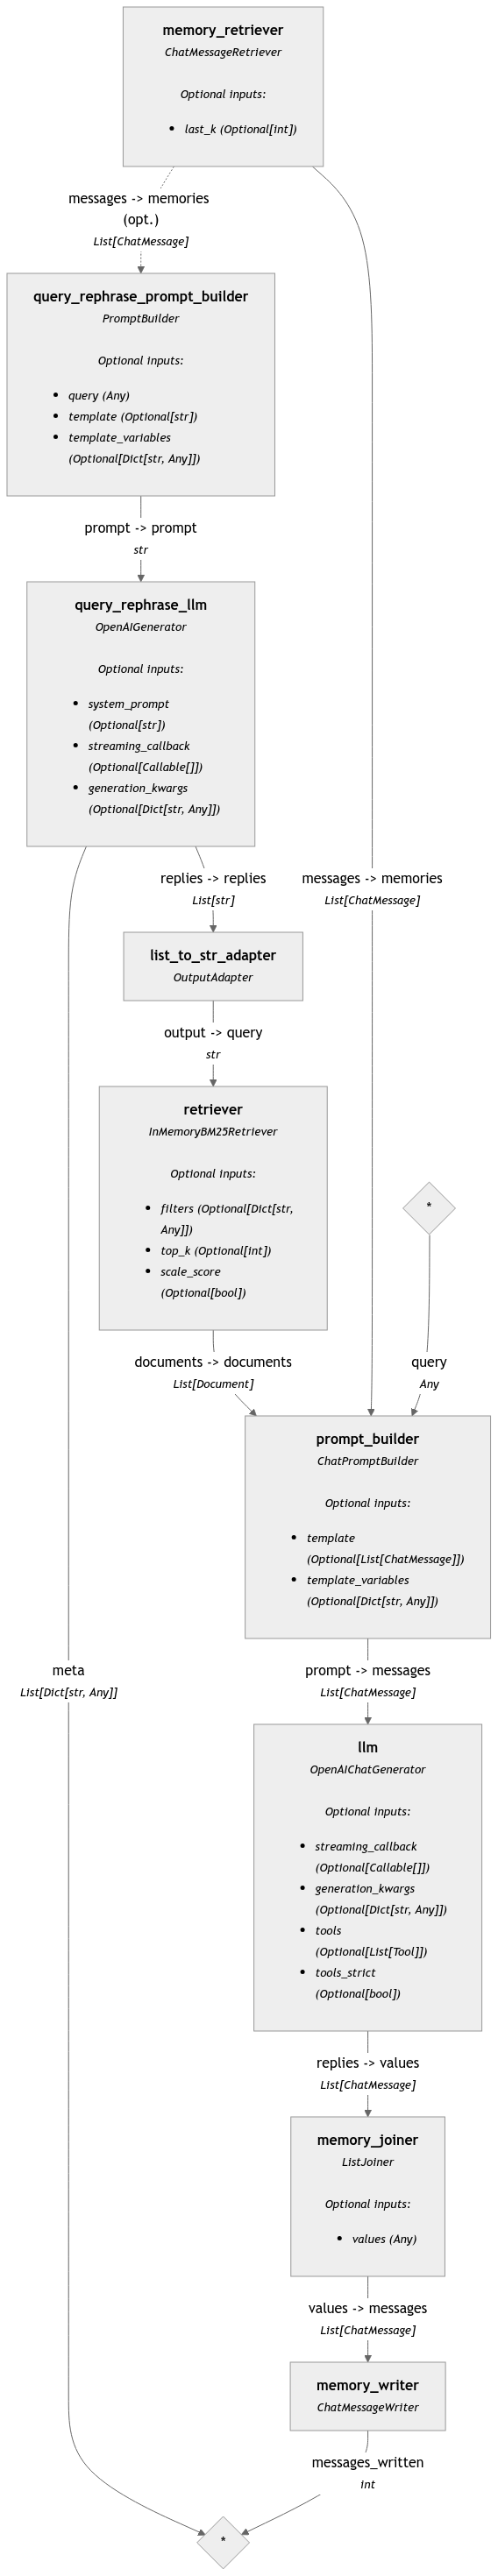

In [11]:
conversational_rag.show()

In [12]:
while True:
    messages = [system_message, user_message]
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question=="Q":
        break

    res = conversational_rag.run(data={"query_rephrase_prompt_builder": {"query": question},
                             "prompt_builder": {"template": messages, "query": question},
                             "memory_joiner": {"values": [ChatMessage.from_user(question)]}},
                            include_outputs_from=["llm","query_rephrase_llm"])
    search_query = res['query_rephrase_llm']['replies'][0]
    print(f"   🔎 Search Query: {search_query}")
    assistant_resp = res['llm']['replies'][0]
    print(f"🤖 {assistant_resp.text}")

   🔎 Search Query: Is artificial intelligence going to replace jobs?
🤖 The supporting documents do not directly address the question of whether AI will take our jobs.
   🔎 Search Query: What is the reason behind that statement?
🤖 The statement was made because the supporting documents do not address the question of whether AI will take our jobs, focusing instead on the use and understanding of AI in various practices and disciplines.
   🔎 Search Query: What do the supporting documents indicate?
🤖 The documents discuss how artificial intelligence is transforming various disciplines and practical contexts, emphasizing the need for interdisciplinary approaches to understand and utilize AI effectively. They introduce a conceptual framework called AI Thinking, which outlines key competencies for applying AI in practice. Additionally, they propose the study of Intersymbolic AI, which combines symbolic and subsymbolic AI to enhance effectiveness and insights from both approaches. Overall, the